#

## Instalando Dependencias 

In [ ]:
# Instalação das dependências
%pip install -r requirements.txt
!python -m spacy download pt_core_news_sm

     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
     ------ --------------------------------- 2.1/13.0 MB 11.3 MB/s eta 0:00:01
     ------------- -------------------------- 4.5/13.0 MB 11.5 MB/s eta 0:00:01
     --------------------- ------------------ 7.1/13.0 MB 11.5 MB/s eta 0:00:01
     ---------------------------- ----------- 9.2/13.0 MB 11.5 MB/s eta 0:00:01
     ---------------------------------- ---- 11.5/13.0 MB 11.5 MB/s eta 0:00:01
     --------------------------------------- 13.0/13.0 MB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Inserindo PDF no Script

In [2]:
import pdfplumber 
def pdfRead(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text = ''
        for page in pdf.pages:
            text += page.extract_text() + '\n'
    return text

pdf_path = 'O-Alquimista-H.P.-Lovecraft.pdf'
pdf_text = pdfRead(pdf_path)


print(len(pdf_text)) # Contagem de caracteres contando espaços

22331


## Adicionando Stopwords do NLTK e Custom

In [3]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') 

stop_words =  set(stopwords.words('portuguese'))
custom_stopwords = { 'de','a', 'do' ,'da', 'e','deles','delas','com' }

used_stop_words = stop_words.union(custom_stopwords)

print(f'Total stopwords: {len(used_stop_words)}')
print(used_stop_words)

Total stopwords: 207
{'meu', 'as', 'estivesse', 'pela', 'teremos', 'foram', 'na', 'esteja', 'estivermos', 'muito', 'vos', 'seja', 'tivessem', 'num', 'tuas', 'mesmo', 'ele', 'houveremos', 'suas', 'haver', 'fui', 'aquelas', 'o', 'nós', 'sem', 'no', 'seria', 'à', 'houvera', 'será', 'pelo', 'da', 'lhes', 'estivemos', 'delas', 'hão', 'seríamos', 'estas', 'for', 'já', 'fôramos', 'houver', 'qual', 'éramos', 'tivéssemos', 'foi', 'teriam', 'isto', 'houvéssemos', 'houvéramos', 'também', 'fomos', 'eles', 'seus', 'tivesse', 'tem', 'tém', 'houveria', 'esta', 'tínhamos', 'que', 'essas', 'como', 'terão', 'há', 'essa', 'para', 'uma', 'tu', 'minhas', 'isso', 'aos', 'nos', 'teu', 'vocês', 'com', 'tinha', 'pelas', 'tinham', 'teria', 'deles', 'estejam', 'seremos', 'ao', 'sou', 'entre', 'dele', 'são', 'havemos', 'elas', 'ou', 'depois', 'tiver', 'tenhamos', 'esses', 'nas', 'tua', 'temos', 'teríamos', 'fôssemos', 'você', 'sejam', 'das', 'minha', 'forem', 'estivéramos', 'tenho', 'estamos', 'teve', 'um', 'dela

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mark\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Tratamento PLN usando Spacy e Regex

In [4]:
import re 
import spacy

nlp = spacy.load('pt_core_news_sm')

def preprocess_text(text, print_tokens = False):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text) 
    text = re.sub(r'[^a-zà-ú0-9 ]', '', text) 
    
    doc  = nlp(text)

    tokens = [token.text for token in doc]

    # O PDF é literário 
    # Portanto, a lematização é preferida para preservar o significado das palavras
    # Já que no PDF dado contexto se mostra importante, stemming ia perder muito significado e contexto
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct]

    if print_tokens:
        print(f'Original tokens: {tokens[:10]}')
        print(f'Lemmatized tokens: {cleaned_tokens[:10]}')

    final_text = ' '.join(cleaned_tokens)
    return final_text

preprocessed_text = preprocess_text(pdf_text, True)

print(f'Original text length: {len(pdf_text)}')
print(f'Preprocessed text length: {len(preprocessed_text)}')

print(preprocessed_text[:500]) 


Original tokens: ['wwwsitelovecraftcom', 'de3103yahoocombr', 'o', 'alquimista', ' ', 'hp', 'lovecraft', 'tradução', 'renato', 'suttana']
Lemmatized tokens: ['wwwsitelovecraftcom', 'de3103yahoocombr', 'alquimista', ' ', 'hp', 'lovecraft', 'tradução', 'Renato', 'suttano', 'renato']
Original text length: 22331
Preprocessed text length: 15615
wwwsitelovecraftcom de3103yahoocombr alquimista   hp lovecraft tradução Renato suttano renato suttano Renato suttano doutor letra professor Faculdade Educação universidade federal grande dourar autor visita fantasma noite poesio 2002 João cabral melo neto poeta voz modernidade ensaio 2005 bicho poesia 2005 fim verão poesia 2009 poética deslimite poema imagem obra Manoel barro ensaio 2009 além outro publicar Internet suttano manter site web httpwwwarquivorscom contato tradutor poder fazer email r


## Chunking Recursivo no PDF usando Text Splitter do LangChain

In [28]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


# Valores ajustados de acordo com testes 
chunk_size = 110
chunk_overlap = 22

# Utilizando Chunking Recursivo para melhor divisão do texto já que o texto é um livro
# e contem várias seções, capítulos e parágrafos, sendo organizado hierarquicamente

# Um chunking fixo, poderia cortar introduções de parágrafos e capitulos de forma inadequada.
# (Um chunking fixo no exemplo atual funcionaria razoavelmente bem mas prefiro usar o recursivo de exemplo)
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", "", "."],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

text_chunks = text_splitter.split_text(preprocessed_text)

print(f'Number of text chunks: {len(text_chunks)}')
print(f'First text chunk: {text_chunks[0]}')

Number of text chunks: 178
First text chunk: wwwsitelovecraftcom de3103yahoocombr alquimista   hp lovecraft tradução Renato suttano renato suttano Renato


## Inserção dos Chunks e Embeddings no ChromaDB

In [29]:
from sentence_transformers import SentenceTransformer
import chromadb 

client = chromadb.Client()
model_name = 'all-MiniLM-L6-v2' # 

model = SentenceTransformer(
    model_name
)
embeddings = model.encode(text_chunks)

ids = [f'chunk_{i}' for i in range(len(text_chunks))]

if 'pdf_chunks' in [col.name for col in client.list_collections()]:
    client.delete_collection(name='pdf_chunks')

collection = client.create_collection(name='pdf_chunks')


collection.add(
    ids=ids,
    documents=text_chunks,
    embeddings=embeddings.tolist()
)
    

## Query de Exemplo ao Banco e Plotting de Distancia de Resultados

Best result for query: 'Quem é Renato Suttana?'
Result:renato suttano Renato suttano doutor letra professor Faculdade Educação universidade federal grande dourar... 
distance: 0.8302



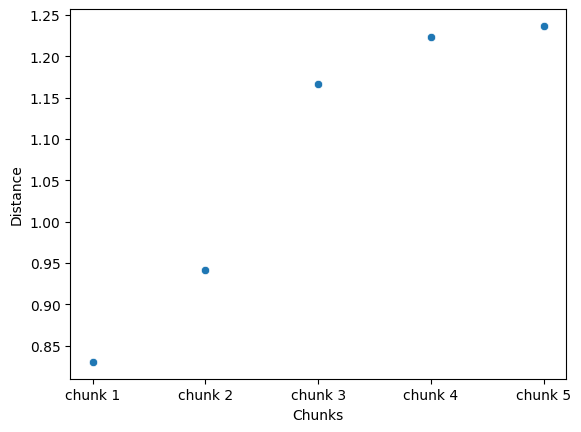

In [ ]:
import seaborn as sb 
import matplotlib.pyplot as plt
raw_query = "Quem é Renato Suttana?"
query = preprocess_text(raw_query)
query_embedding = model.encode([query])

results = collection.query(query_embeddings=query_embedding.tolist(), n_results=5, include=['documents','distances'])

# Melhor Resultado da Query e sua distancia 

# A Query não dá diretamente a resposta, mas traz o chunk mais relevante, 
# no caso uma resposta mais precisa seria realizada se o chunk fosse menor 
# ou se o contexto fosse passado para uma IA de linguagem natural, onde ela utilizaria de contexto

print(f"Best result for query: '{raw_query}'")
print(f"Result:{results['documents'][0][0][:500]}...",f"\ndistance: {results['distances'][0][0]:.4f}\n")

# Plot para visualizar as distâncias dos chunks retornados
# A Distancia é a distância do embedding da query para o embedding do chunk, quanto mais próximo de 0, 
# mais relevante o chunk é a query, no caso do modelo utilizado (all-MiniLM-L6-v2) 
# a distancia é calculada via cosseno

sb.scatterplot(x=[f'chunk {i+1}' for i in range(len(results['distances'][0]))], y=results['distances'][0])
plt.ylabel('Distance')
plt.xlabel('Chunks')
plt.show()

In [ ]:
import pandas as pd
data = {
    'Chunk': [f'chunk {i+1}' for i in range(len(results['distances'][0]))],
    'Distance': results['distances'][0],
    'Document': results['documents'][0]
}
df = pd.DataFrame(data)
print(df)

     Chunk  Distance                                           Document
0  chunk 1  0.830209  renato suttano Renato suttano doutor letra pro...
1  chunk 2  0.941792  wwwsitelovecraftcom de3103yahoocombr alquimist...
2  chunk 3  1.166218  poema imagem obra Manoel barro ensaio 2009 alé...
3  chunk 4  1.223099  todo arrancar vida feliz virtuosa pouco menos ...
4  chunk 5  1.236721  articular palavra incompreensível dar momento ...
